In [1]:
import matplotlib.pyplot as plt
import json
import os
import cv2
import time
import numpy as np
from csbdeep.utils import Path, normalize
from segmentation import MELC_Segmentation
import pickle

2023-06-01 10:06:22.654870: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-01 10:06:22.656050: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 10:06:22.681271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-01 10:06:22.681658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 10:06:23.084117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data = "ALS"

f = open('/data_slow/je30bery/spatial_proteomics/config.json')
config = json.load(f)
data_path = config[data]
seg = MELC_Segmentation(data_path, membrane_marker="cd45") 
# membrane_marker: str/None 
# radius: multiple of cell radius
print(seg.fields_of_view)

['ALS01 - 21297', 'ALS01 - 21298', 'ALS01 - 21299', 'ALS01 - 21300', 'ALS02 - 21301', 'ALS02 - 21302', 'ALS02 - 21303', 'ALS02 - 21304', 'ALS03 - 21305', 'ALS03 - 21306', 'ALS03 - 21307', 'ALS03 - 21308', 'Healthy01 - 21315', 'Healthy01 - 21316', 'Healthy01 - 21317', 'Healthy01 - 21318', 'Healthy02 - 21319', 'Healthy02 - 21320', 'Healthy02 - 21321', 'Healthy02 - 21322', 'Healthy03 - 21323', 'Healthy03 - 21324', 'Healthy03 - 21325', 'Healthy03 - 21326', 'Healthy04 - 21335', 'Healthy04 - 21336', 'Healthy04 - 21337', 'Healthy04 - 21338', 'Healthy05 - 21331', 'Healthy05 - 21332', 'Healthy05 - 21333', 'Healthy05 - 21334']


In [51]:
seg.fov_dir ='ALS01 - 21297'
markers = {m.split("_")[1]: os.path.join(seg.get_fov_dir(), m) for m in sorted(os.listdir(seg.get_fov_dir())) if m.endswith(".tif") and "phase" not in m}
mimg = cv2.imread(markers["CD16-PE"], cv2.IMREAD_GRAYSCALE)
tile_std = np.std(mimg)
plt.clf()
adaptive = cv2.adaptiveThreshold(mimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 401, -5*tile_std)  
plt.imsave("adpative.png", adaptive, cmap="hot")

<Figure size 500x400 with 0 Axes>

for i, fov in enumerate(seg.fields_of_view):
    seg.field_of_view = fov
    nuc, mem = seg.run(fov)
    np.save(f"./segmentation_results/{fov}_nuclei.npy", nuc.astype(int))
    np.save(f"./segmentation_results/{fov}_membranes.npy", mem.astype(int))

    with open(f'./segmentation_results/{fov}_nuclei.pickle', 'wb') as handle:
        pickle.dump(seg.nucleus_label_where[fov], handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'./segmentation_results/{fov}_membrane.pickle', 'wb') as handle:
        pickle.dump(seg.membrane_label_where[fov], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [100]:
#plt.imsave("mimg.png", mimg, cmap="gray")

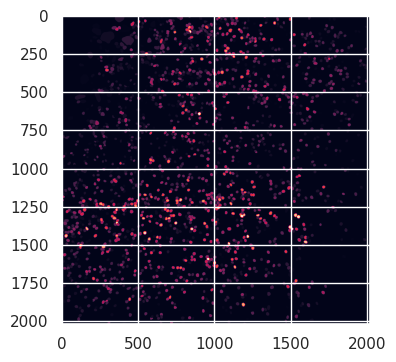

In [113]:
ms = ["CD16-PE", "CD11b-PE", "HLA-DQ-FITC"]
exs = list()
for m in ms:
    mimg = cv2.imread(markers[m], cv2.IMREAD_GRAYSCALE)
    #plt.imshow(mimg)
    tile_std = np.std(mimg)
    adaptive = cv2.adaptiveThreshold(mimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 401, -2*tile_std)  
    #plt.imsave("adaptive.png", adaptive, cmap="hot")
    ex = get_expression(adaptive, where_dict_nuc)
    exs.append(ex)


In [103]:
plt.imsave("expression.png", ex, cmap="hot")

In [4]:
def get_expression(adaptive, where_dict):
    expression = np.zeros_like(adaptive)
    for n in where_dict:
        if n == 0:
            continue
        
        segment = where_dict[n]
        exp = np.sum(adaptive[segment[0], segment[1]])/len(segment[0])
        expression[segment[0], segment[1]] = exp
    return expression

In [23]:
plt.imshow(cd45)

NameError: name 'cd45' is not defined

In [22]:
plt.imsave("mem_seg.png", membranes, cmap="bone")

In [69]:
from tqdm import tqdm
result = dict()
plot = False 

for fov in tqdm(seg.fields_of_view[:1]):
    seg.field_of_view = fov
    nuclei = np.load(f"./segmentation_results/{fov}_nuclei.npy")
    membranes = np.load(f"./segmentation_results/{fov}_membranes.npy")

    with open( f"./segmentation_results/{fov}_nuclei.pickle", 'rb') as handle:
        where_dict_nuc = pickle.load(handle)
    with open( f"./segmentation_results/{fov}_membrane.pickle", 'rb') as handle:
        where_dict_mem = pickle.load(handle)

    c = np.concatenate(list(where_dict_nuc.values()), axis=1) #TODO

    markers = {m.split("_")[1]: os.path.join(seg.get_fov_dir(), m) for m in sorted(os.listdir(seg.get_fov_dir())) if m.endswith(".tif") and "phase" not in m}
    window_size = 201
    #rem = int(2018 % window_size)
    #x1 = rem // 2
    #x2 = rem - x1
    expressions = np.ndarray((len(markers), 2018*2018))
    
    if plot:
        f, axs = plt.subplots(2, 4, figsize=(20, 10))
    
    combs = list()
    res = np.empty((4, 2018, 2018), dtype=int)
    d = 0
    combined_condition = None
    for i,m in enumerate(markers):
        if m not in ['HLA-DR-PE', 'CD11b-PE', 'CD16-PE', 'CD45RA-PE']: #hladr:0, cd11:0, cd16:1, cd45ra:1 #TODO
        #if m not in ['HLA-DQ-FITC', 'CD11b-PE', 'CD16-PE']: #TODO
            continue
        m_img = cv2.imread(markers[m], cv2.IMREAD_GRAYSCALE)    
        if plot:
            axs[0,d].imshow(m_img, cmap="gray")
            axs[0,d].set_title(f"{m} Original Image")
            axs[0,d].axis("off")
        tile_std = np.std(m_img)
        adaptive = cv2.adaptiveThreshold(m_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, window_size, -2*tile_std)  
        expression = get_expression(adaptive, where_dict_nuc) #TODO 
        
        thresh = np.mean(expression[c[0], c[1]])
        
        if m == "CD16-PE" or m == 'CD45RA-PE': # TODO
            condition = (expression > thresh)
        else:
            condition = (expression < thresh)# * (expression > 0)
            
        combs.append(condition)
        if combined_condition is None:
            combined_condition = condition 
        else: 
            combined_condition = np.logical_and(combined_condition, condition)
        
        
        if plot:
            colored = np.zeros((2018, 2018, 3), dtype=int)
            colored[:,:,d] = expression.astype(int)
       
            axs[1,d].imshow(colored)
            axs[1,d].set_title(f"{m} Expression within Nuclei")
            axs[1,d].axis("off")
            res[d] = expression
        d += 1

    assert np.sum(combined_condition) <= c.shape[1]
    if plot:
        axs[0,-1].imshow(nuclei > 0, cmap="gray")
        axs[0,-1].set_title("Segmented Nuclei")
        axs[0,-1].axis("off")

        axs[1,-1].imshow(res.transpose((1, 2, 0)))
        axs[1,-1].set_title("Combined")
        axs[1,-1].axis("off")

    condition_cells = np.sum(combined_condition) / c.shape[1]
    result[fov] = condition_cells
    
    if plot:
        plt.tight_layout()
        plt.show()
    #plt.savefig(f"{fov}_patent.pdf")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


In [115]:
plt.imsave("comb.png", combined_condition, cmap="gray")

Text(0.5, 1.0, 'Profile CD11b:0, CD16:1, HLA-DQ:0, Expression within Cells (Nuclei and Cytoplasm)')

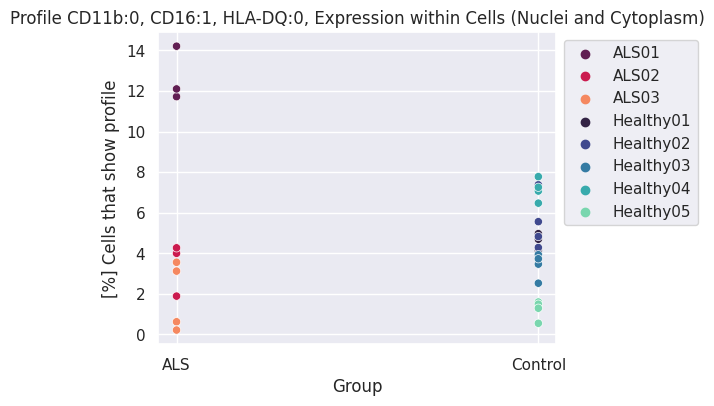

In [66]:
import seaborn as sns
import pandas as pd

pal = sns.color_palette("rocket", 3) + sns.color_palette("mako", 5)
index = result.keys()
vals = result.values()
sns.set(rc={'figure.figsize':(5,4)})

df = pd.DataFrame(np.array([list(index), list(vals)]).T, columns=["ID", "Condition cells"])
df["Group"] = np.where(df["ID"].str.contains("ALS"), "ALS", "Control")
df["Patient"] = df["ID"].apply(lambda x: x.split(" ")[0])
df["Condition cells"] = df["Condition cells"].astype(float) * 100

plt.clf()
sns.set_theme()
sns.scatterplot(data=df, x="Group", y="Condition cells", hue="Patient", palette=pal)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("[%] Cells that show profile") #TODO
#plt.title("Profile CD11b:0, CD16:1, CD45-RA:1, HLA-DR:0, Expression within Nuclei") #TODO
plt.title("Profile CD11b:0, CD16:1, HLA-DQ:0, Expression within Cells (Nuclei and Cytoplasm)") #TODO
#plt.savefig("expr_mem_1.pdf", bbox_inches='tight') #TODO

In [ ]:
list(pal)

In [ ]:
df["group"] = np.where("ALS" in df.index, "ALS", "Control")

In [ ]:
"ALS"  list(df.index)

In [ ]:
list(df.index)

In [ ]:
plt.imshow(np.logical_and(np.logical_and(combs[0], combs[1]), combs[2]))

In [ ]:
np.sum(np.logical_and(np.logical_and(combs[0], combs[1]), combs[2]))

In [ ]:
len(c[0])

In [ ]:
np.sum(combined_condition)

In [ ]:
combined_condition

In [ ]:
plt.imshow(nuclei > 0)

In [ ]:
plt.imshow(combined_condition)
plt.show()
print(np.sum(combined_condition))

In [ ]:
print(c.shape[1])

In [ ]:
condition_cells

In [ ]:
247086/1162532

In [ ]:
df

In [ ]:
plt.imshow(condition)

In [ ]:
.shape

In [ ]:
c = np.concatenate(list(where_dict_nuc.values()), axis=1)
vals = m_img[c[0], c[1]] 
print(np.mean(vals))
plt.imshow(expression > np.mean(vals))

In [ ]:
import seaborn as sns
sns.displot(vals.flatten())

In [ ]:
2018*2018

In [ ]:
markers.keys()

In [ ]:
from tqdm import tqdm

fov = 'ALS03 - 21307'
seg.field_of_view = fov
nuclei = np.load(f"./segmentation_results/{fov}_nuclei.npy")
membranes = np.load(f"./segmentation_results/{fov}_membranes.npy")

with open( f"./segmentation_results/{fov}_nuclei.pickle", 'rb') as handle:
    where_dict_nuc = pickle.load(handle)
with open( f"./segmentation_results/{fov}_membrane.pickle", 'rb') as handle:
    where_dict_mem = pickle.load(handle)
    

markers = {m.split("_")[1]: os.path.join(seg.get_fov_dir(), m) for m in os.listdir(seg.get_fov_dir()) if m.endswith(".tif") and "phase" not in m}
window_size = 201
#rem = int(2018 % window_size)
#x1 = rem // 2
#x2 = rem - x1

f, axs = plt.subplots(len(markers), 4, figsize=(15,100))
#f, axs = plt.subplots(5, 4, figsize=(15,25))

    
for i,m in enumerate(tqdm(markers)):
    
    m_img = cv2.imread(markers[m], cv2.IMREAD_GRAYSCALE)    
    axs[i,0].imshow(m_img, vmin=0, vmax=255)
    axs[i,0].axis("off")
    #cropped = m_img[x1:-x2, x1:-x2]
    #tiles = cropped.reshape(int((cropped.shape[0]**2)/(window_size**2)), window_size, window_size) 
    #stds = np.std(tiles, axis=(1,2))
    #tile_std = np.mean(stds)
    tile_std = np.std(m_img)
    adaptive = cv2.adaptiveThreshold(m_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, window_size, -tile_std)
    axs[i,1].imshow(adaptive, vmin=0, vmax=255)
    axs[i,1].axis("off")
    
    axs[i,2].imshow(adaptive * (nuclei > 0), vmin=0, vmax=255)
    axs[i,2].axis("off")
    
    expression = get_expression(adaptive, where_dict_nuc)
    axs[i,3].imshow(expression, vmin=0, vmax=255)
    axs[i,3].axis("off")
    
plt.tight_layout()
plt.savefig("expression.pdf")

In [ ]:
bin_expression

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
ex = pd.DataFrame(expressions.T, columns=list(markers.keys()))
ex

In [ ]:
sns.boxplot(ex)

In [ ]:
plt.clf()
f, axs = plt.subplots(4, 3, figsize=(15,15))
axs[0, 0].imshow(m_img)
axs[0, 0].axis("off")
axs[0, 0].set_title("Original marker image")
axs[1, 0].imshow(m_img[300:500,300:500])
axs[1, 0].axis("off")

axs[0, 1].imshow(m_img * (nuclei > 0))
axs[0, 1].axis("off")
axs[0, 1].set_title("Original marker image where nuclei")
axs[1, 1].imshow((m_img * (nuclei > 0))[300:500,300:500])
axs[1, 1].axis("off")

axs[0, 2].imshow(m_img * (membranes > 0))
axs[0, 2].axis("off")
axs[0, 2].set_title("Original marker image where membranes or nuclei")
axs[1, 2].imshow((m_img * (nuclei > 0))[300:500,300:500])
axs[1, 2].axis("off")

blurred_m_img = cv2.GaussianBlur(m_img, (5,5), 0)
threshold, thresh_m_img = cv2.threshold(blurred_m_img, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

m_img_within_nuclei = m_img * (nuclei > 0)
threshold, thresh_nuclei_m_img = cv2.threshold(m_img_within_nuclei, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

m_img_within_membranes = m_img * (membranes > 0)
threshold, thresh_mebrane_m_img = cv2.threshold(m_img_within_membranes, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

axs[2, 0].imshow(thresh_m_img)
axs[2, 0].axis("off")
axs[3, 0].imshow(thresh_m_img[300:500,300:500])
axs[3, 0].axis("off")

axs[2, 1].imshow(thresh_nuclei_m_img)
axs[2, 1].axis("off")
axs[3, 1].imshow(thresh_nuclei_m_img[300:500,300:500])
axs[3, 1].axis("off")

axs[2, 2].imshow(thresh_mebrane_m_img)
axs[2, 2].axis("off")#
axs[3, 2].imshow(thresh_mebrane_m_img[300:500,300:500])
axs[3, 2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
window_size = 201
rem = int(m_img.shape[0] % window_size)
x1 = rem // 2
x2 = rem - x1
cropped = m_img[x1:-x2, x1:-x2]
tiles = cropped.reshape(int((cropped.shape[0]**2)/(window_size**2)), window_size, window_size) 
stds = np.std(tiles, axis=(1,2))
tile_std = np.mean(stds)

adaptive = cv2.adaptiveThreshold(m_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 201, -tile_std)
plt.imshow(adaptive)

In [ ]:
plt.imshow(adaptive * (nuclei > 0))

In [ ]:
expression = np.zeros_like(nuclei)
for n in np.unique(nuclei):
    if n == 0:
        continue
    segment = np.where(nuclei == n)
    expression[segment] = np.sum(adaptive[segment])/len(segment[0])
plt.imshow(expression, cmap="gray")

In [ ]:
import seaborn as sns
sns.displot(expression.flatten(), kind="kde")